In [9]:
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from convnets.utilities import utils

In [2]:
# dimensions of our images.
img_width, img_height = 224, 224

# structure_path = '/home/mksnkv/models/top_tuned/vgg16/structure_passport.json'
weights_path_mcp = '/home/mksnkv/models/top_tuned/vgg16/snils_model_mcp.h5'
train_data_dir = '/home/mksnkv/Documents/classification/snils_2class_divided_clean/train'
validation_data_dir = '/home/mksnkv/Documents/classification/snils_2class_divided_clean/validation'
nb_train_samples = 480
nb_validation_samples = 130
nb_evaluation_samples = 780
epochs = 10
batch_size = 10

In [3]:
def train_top_model():
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=(img_width, img_height, 3))
    model = Sequential()
    
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    for layer in base_model.layers[:-4]:
        layer.trainable = False
#     for layer in base_model.layers:
#         print(layer)
    model.summary()
    opt = Adam(learning_rate=1e-5)
    model.compile(optimizer=opt,
                  loss='binary_crossentropy', metrics=['accuracy'])

    mcp_save = ModelCheckpoint(weights_path_mcp, save_best_only=True, monitor='val_loss', mode='min')
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    history = model.fit_generator(
            generator=train_generator,
            steps_per_epoch=nb_train_samples // batch_size,
            epochs=epochs,
             callbacks = [mcp_save],
            validation_data=val_generator,
            validation_steps=nb_validation_samples // batch_size)
    return model, history

In [4]:
train_generator, val_generator = utils.init_generators(train_data_dir, 
                                                       validation_data_dir, 
                                                       img_width, 
                                                       img_height, 
                                                       batch_size,
                                                       batch_size)

Found 490 images belonging to 2 classes.
Found 130 images belonging to 2 classes.


In [5]:
model, history = train_top_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 21,137,729
Trainable params: 13,502,465
Non-trainable params: 7,635,264
_________________________________________________________________
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


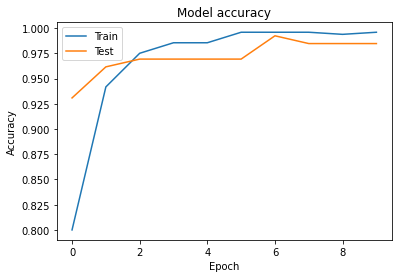

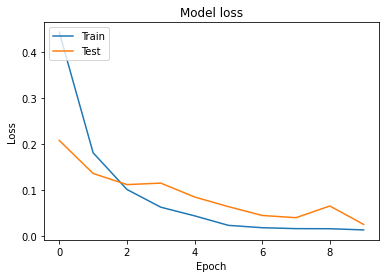

In [6]:
utils.plot(history)

In [7]:
evaluation_data_dir = '/home/mksnkv/Documents/classification/passport_2class_divided_clean/evaluation'
def evaluation(model):
    datagen = ImageDataGenerator(rescale=1. / 255)
    generator = datagen.flow_from_directory(
        evaluation_data_dir,
        target_size=(img_width, img_height),
        batch_size=1,
        class_mode='binary',
        shuffle=False)
    model1 = load_model(weights_path_mcp)
    model1.evaluate(
        generator, steps = 366 // batch_size)
    model1.predict(
        generator, steps = 366 // batch_size)

In [8]:
evaluation(model)

NameError: name 'ImageDataGenerator' is not defined

In [ ]:
evaluation_labels = np.array(
        [0] * (nb_evaluation_samples // 2) + [1] * (nb_evaluation_samples // 2))
model.test_on_batch(features, evaluation_labels)

In [ ]:
model.predict_on_batch(features)